In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
#import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, Flatten
from scipy import signal
import scipy
#import os
import h5py
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

In [2]:
# Generates a randomized timeshift, outputs that timeshift and the corresponding angle
def timeshift_gen(D):
    """
    D - distance between elements
    """
    #Random angle that the signal is approaching at (-60 to 60)
    #Most phased arrays go -60 to 60 degrees
    angle = np.random.uniform(-1,1)*60
    c = 3e8 # Speed of light
    
    #Calculate the time difference between the two antenna elements
    angle_rad = np.radians(angle)
    timeshift = (np.sin(angle_rad)*D)/c
    
    return timeshift, angle

In [3]:
#Apply the timeshift to the signal
def apply_shift(signal, timeshift, fc, fs):
    # delta(t0) -> exp(-2j*omega*t0)
    # delta(t1) -> exp(-2j*omega*t1)
    # nyquist_component = sum signal[n] * exp(-2j*pi*1/2*n)
    #                   = sum signal[n] * exp(-j*pi*n)
    #                   = sum signal[n] * -1^n
    # nyquist_component of delta(t0) = exp(-j*pi*t0/ts)/2 + exp(j*pi*t0/ts)/2
    #                                = cos(pi*t0/ts)

    # Make sure the signal is an even amount of samples
    n = len(signal)
    assert n%2 == 0 
    
    # Perform an FFT on the signal
    signal_1_f = np.fft.fft(signal)
    signal_1_f = np.fft.fftshift(signal_1_f)
    
    # Get the value from the first index
    signal_1_f_0 = signal_1_f[0]
    
    # Create a frequency array using the sampling frequency and center frequency
    freqs = np.array(range(-n//2, n//2))/n * fs
    freqs = freqs + fc
    
    # Apply the timeshift
    signal_1_f = signal_1_f*np.exp(-1j*2*np.pi*freqs*timeshift)
    signal_1_f[0] = signal_1_f_0 * np.cos(2*np.pi*fs/2*timeshift) * np.exp(-1j*2*np.pi*fc*timeshift)
    
    # Convert from FFT to time signal
    signal_1_f = np.fft.fftshift(signal_1_f)
    signal_1_t = np.fft.ifft(signal_1_f)
    
    return signal_1_t

In [4]:
# This function takes the signals data/labels, and seperates them into seperate NN inputs
# It will output the different datasets and lables.

def corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth):
    
    # Create arrays to store the labels, and datasets 
    n = len(signal_0[0])
    dataset2 = []
    labels2 = []
    dataset = []
    dataset3 = []
    labels3 = []
    labels = []
    temp_real = []
    temp_imag = []
    temp_corr = []

    # Perform the correllation for use in the AoA prediction
    for i in range(len(signal_0)):
        temp = signal.correlate(signal_0[i], signal_1[i], mode ='same', method = 'auto')
        temp_corr.append(temp) 
    
    # Split correlation information into it's real component and normalize
    temp_real = np.real(temp_corr)
    temp_real = temp_real/100
    
    # Split the correlation information into it's imaginary component and normalize
    temp_imag = np.imag(temp_corr)
    temp_imag = temp_imag/(2*np.pi)
    
    # Convert the angle labels to radians and normalize
    angles = np.radians(angles)
    angles_scaled = angles/(np.pi/2)
    
    # Perform the FFT of the signal for use in the frequency portion of the network
    signal_0_f = np.fft.fft(signal_0); #signal_0_f = np.fft.fftshift(signal_0_f)
    
    for i in range(len(temp_real)):
        # Append the correlated signal parts (real and imaginary) into a single array
        sigs = [temp_real[i], temp_imag[i]]
        
        # Append the angle labels into an array
        params = angles_scaled[i]
        
        # Append the start/stop time labels into a sinle array
        params2 = [starts[i]/len(signal_0[0]), stops[i]/len(signal_0[0])]
        
        # Append the frequency (center freq / bandwidth) labels into a single array
        params3 = [center[i], bandwidth[i]]
        
        # Append the labels and datasets into a singular new array
        dataset.append(sigs)
        dataset2.append(signal_0[i])
        dataset3.append(np.abs(signal_0_f[i]))
        labels.append(params)
        labels2.append(params2)
        labels3.append(params3)
        
    return dataset, dataset2, dataset3, labels, labels2, labels3

In [5]:
#This function takes the two signals and applies noise
def add_noise(signal, noise):
    # Generate randomized real and imaginary noise
    real_noise_0 = np.random.normal(0,noise, len(signal))
    imag_noise_0 = 1j*np.random.normal(0,noise, len(signal))
    
    # Add the noise to the signal
    signal_noise = signal + real_noise_0 + imag_noise_0

    return signal_noise

In [6]:

# Read in the files for training (/data/signal_discover_cnn/2048_Angles_First.h5) is the file available on the binder
with h5py.File("Anechoic_Data.h5", "r") as f:
    # List all groups
    items = f.keys()               #Checks what "folders" are within the file
    G1 = f.get('generated_data')   #Gets the contents of the generated data folder
    
    # Collect the signals and store them into an array
    signal_0 = np.array(G1.get('dataset'));
    
    # Collect the labels and store them into arrays
    starts = np.array(G1.get('starts'));
    stops = np.array(G1.get('stops'));
    center = np.array(G1.get('centers'))
    bandwidth = np.array(G1.get('bandwidths'))
    #angles = np.array(G1.get('angles'));
    print(len(signal_0))
    
    

10000


C:\Users\rproc\anaconda3\envs\SignalDiscovery\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


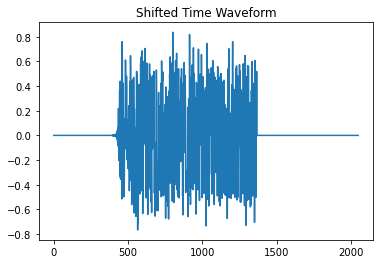

In [7]:
plt.plot(signal_0[6])
#plt.xlabel("Samples")
#plt.ylabel("Amplitude")
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
plt.title("Shifted Time Waveform")
plt.show()

In [8]:
# Define an array for time shifted signals
signal_1 = []

# Define an array for the angle
angles = []

D = 0.05 # Distance between elements
fc = 2e9 # Center Frequency
fs = 5e6 # Sampling frequency

for i in range(len(signal_0)):
    timeshift, temp_angle = timeshift_gen(D) # Get the angle and time delay
    signal_1_t = apply_shift(signal_0[i], timeshift, fc, fs)  # Apply the timeshift
    signal_1.append(signal_1_t) # Append the signal to a list
    angles.append(temp_angle) # Append the angle to a list

# Conver to numpy arrays
signal_1 = np.array(signal_1)
angles = np.array(angles)

C:\Users\rproc\anaconda3\envs\SignalDiscovery\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


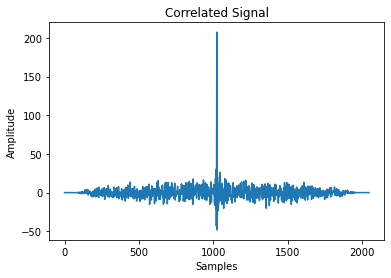

In [9]:
temp = signal.correlate(signal_0[6], signal_1[6], mode ='same', method = 'auto')
plt.plot(temp)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Correlated Signal")
plt.show()

In [10]:
# Add noise to each of the signals
# Varying noise levels for each of the signals
for i in range(len(signal_0)):
    noise = np.random.uniform(0,0.2) # Generate a random noise value
    
    # Add noise to each of the signals
    signal_0[i] = add_noise(signal_0[i], noise)
    signal_1[i] = add_noise(signal_1[i], noise)

In [11]:
# Pass the signals and the labels into the data prep function
# This will perform pre processing on the signals (FFT, Correlation) and some normalization. Then it will output the data and labels into seperate lists
angleX, timeX, freqX, angleY, timeY, freqY = corr_data(signal_0, signal_1, angles, starts, stops, center, bandwidth)

In [12]:
#Convert the datasets to numpy arrays
angleX = np.array(angleX)
timeX = np.array(timeX)
angleY = np.array(angleY)
timeY = np.array(timeY)
freqX = np.array(freqX)
freqY = np.array(freqY)

In [14]:
import warnings
warnings.filterwarnings('ignore')
load_model = keras.models.load_model("All_In_One_NN_2048.h5")

history = load_model.evaluate([angleX, timeX, freqX], [angleY, timeY, freqY])
results = load_model.predict([angleX, timeX, freqX])

313/313 [==============================] - 11s 36ms/step - loss: 0.0070 - Angle_Out_loss: 0.0066 - Time_Out_loss: 1.0228e-04 - Frequency_Out_loss: 2.4502e-04 - Angle_Out_Angle_Out_mean_absolute_error: 0.0623 - Time_Out_Time_Out_mean_absolute_error: 0.0060 - Frequency_Out_Frequency_Out_mean_absolute_error: 0.0101 5s - loss: 0.0068 - Angle_Out_loss: 0.0065 - Time_Out_loss: 7.7631e-05 - Frequency_Out_loss: 2.1002e-04 - Angle_Out_Angle_Out_mean_absolute_error: 0.0629 - Time_Out_Time_Out_m


In [16]:
# gather the residuals and means
angle_pred = results[0][:,0]*90
st_pred = results[1][:,0]*2048
et_pred = results[1][:,1]*2048
bw_pred = results[2][:,0]
cf_pred = results[2][:,0]

angle_res = angle_pred - angleY*90
st_res = st_pred - timeY[:,0]*2048
et_res = et_pred - timeY[:,1]*2048
bw_res = bw_pred - freqY[:,0]
cf_res = cf_pred - freqY[:,1]

angle_mean = np.mean(angle_pred)
st_mean = np.mean(st_pred)
et_mean = np.mean(et_pred)
bw_mean = np.mean(bw_pred)
cf_mean = np.mean(cf_pred)

# get the R^2 value which is a measure of how well the data fits the regression model i.e. how much does the model differ from a 
# trivial guess of the mean
angle_R2 = 1 - np.sum(np.square(angle_res))/np.sum(np.square(angle_pred-angle_mean))
st_R2 = 1 - np.sum(np.square(st_res))/np.sum(np.square(st_pred-st_mean))
et_R2 = 1 - np.sum(np.square(et_res))/np.sum(np.square(et_pred-et_mean))
bw_R2 = 1 - np.sum(np.square(bw_res))/np.sum(np.square(bw_pred-bw_mean))
cf_R2 = 1 - np.sum(np.square(cf_res))/np.sum(np.square(cf_pred-cf_mean))
print("R2 angles:{}".format(angle_R2))
print("R2 start time:{}".format(st_R2))
print("R2 end time:{}".format(et_R2))
print("R2 bandwidth:{}".format(bw_R2))
print("R2 center freq:{}".format(cf_R2))
print("\n")

# get the RMSE, which represnets the standard deviation of the residuals
angle_RMSE = np.sqrt(np.mean(np.square(angle_res)))
st_RMSE = np.sqrt(np.mean(np.square(st_res)))
et_RMSE = np.sqrt(np.mean(np.square(et_res)))
bw_RMSE = np.sqrt(np.mean(np.square(bw_res)))
cf_RMSE = np.sqrt(np.mean(np.square(cf_res)))
print("RMSE angles:{}".format(angle_RMSE))
print("RMSE start time:{}".format(st_RMSE))
print("RMSE end time:{}".format(et_RMSE))
print("RMSE bandwidth:{}".format(bw_RMSE))
print("RMSE center freq:{}".format(cf_RMSE))
print("\n")

# calculate the mean absolute error this can be compared against the RMSE to see if the output is skewed toward outlier 
# as MAE doesn't weigh outliners as heavily as RMSE but both are in units of the residual
angle_MAE = np.mean(np.abs(angle_res))
st_MAE = np.mean(np.abs(st_res))
et_MAE = np.mean(np.abs(et_res))
bw_MAE = np.mean(np.abs(bw_res))
cf_MAE = np.mean(np.abs(cf_res))
print("MAE angles:{}".format(angle_MAE))
print("MAE start time:{}".format(st_MAE))
print("MAE end time:{}".format(et_MAE))
print("MAE bandwidth:{}".format(bw_MAE))
print("MAE center freq:{}".format(cf_MAE))

R2 angles:0.954640220971293
R2 start time:0.9979092459750156
R2 end time:0.9960359158379374
R2 bandwidth:0.9761285125842629
R2 center freq:-86.74665125427269


RMSE angles:7.332714804791467
RMSE start time:20.285208141986
RMSE end time:21.13027116513675
RMSE bandwidth:0.008927284280474262
RMSE center freq:0.541246249541079


MAE angles:5.610339830646827
MAE start time:12.11519071893692
MAE end time:12.602398135375976
MAE bandwidth:0.006522668103557175
MAE center freq:0.49826130367847854


Angle -- NN Output:  -4.756886288523674 Actual Label:  -7.282588598272119
Start -- CNN Output:  1312.4130859375 Actual Label:  1328.0
Stop -- CNN Output:  1940.67138671875 Actual Label:  1955.0


Center Frequency -- CNN Output:  0.019708028 Actual Label:  0.0365478
Bandwidth -- CNN Output:  0.77879703 Actual Label:  0.7800324


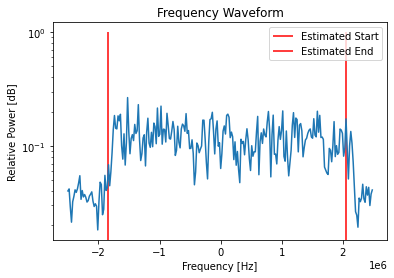


Angle -- NN Output:  34.474990367889404 Actual Label:  21.796526686405578
Start -- CNN Output:  1418.0714111328125 Actual Label:  1417.0
Stop -- CNN Output:  2018.619384765625 Actual Label:  2043.0


Center Frequency -- CNN Output:  0.013737061 Actual Label:  0.012409
Bandwidth -- CNN Output:  0.7582861 Actual Label:  0.7627554



Angle -- NN Output:  48.43874752521515 Actual Label:  49.815495895962144
Start -- CNN Output:  739.9825439453125 Actual Label:  750.0
Stop -- CNN Output:  1936.9189453125 Actual Label:  1954.0


Center Frequency -- CNN Output:  0.024300179 Actual Label:  0.0212628
Bandwidth -- CNN Output:  0.41283715 Actual Label:  0.4109302


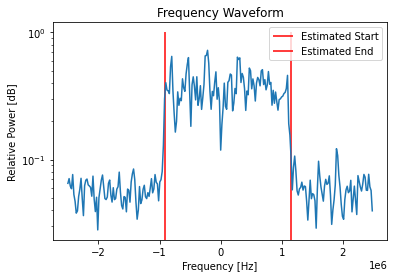


Angle -- NN Output:  45.556676387786865 Actual Label:  40.68099137823292
Start -- CNN Output:  801.4417114257812 Actual Label:  792.0
Stop -- CNN Output:  1621.220458984375 Actual Label:  1598.0


Center Frequency -- CNN Output:  0.12548365 Actual Label:  0.1050522
Bandwidth -- CNN Output:  0.26025286 Actual Label:  0.2577028


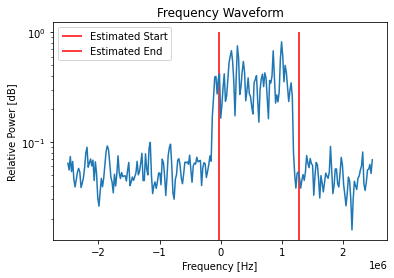


Angle -- NN Output:  52.239872217178345 Actual Label:  49.86053951041295
Start -- CNN Output:  682.1324462890625 Actual Label:  674.0
Stop -- CNN Output:  1679.1630859375 Actual Label:  1663.0


Center Frequency -- CNN Output:  0.060391348 Actual Label:  0.046565
Bandwidth -- CNN Output:  0.7711491 Actual Label:  0.7484026


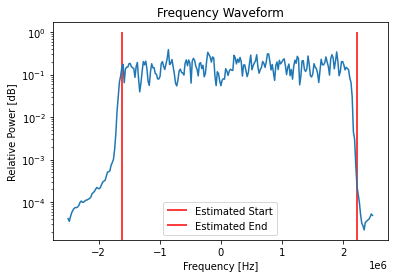


Angle -- NN Output:  44.6809646487236 Actual Label:  45.498444001806426
Start -- CNN Output:  598.769775390625 Actual Label:  601.0
Stop -- CNN Output:  1824.89013671875 Actual Label:  1829.0


Center Frequency -- CNN Output:  -0.085578814 Actual Label:  -0.0842814
Bandwidth -- CNN Output:  0.49137026 Actual Label:  0.4699238



Angle -- NN Output:  36.44655615091324 Actual Label:  26.571418246115382
Start -- CNN Output:  249.46739196777344 Actual Label:  250.0
Stop -- CNN Output:  998.6251220703125 Actual Label:  995.0


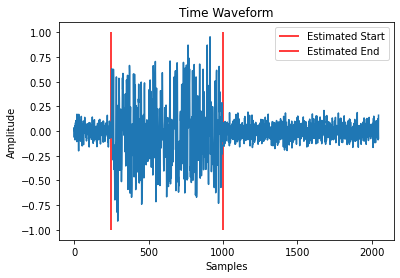

Center Frequency -- CNN Output:  0.018835055 Actual Label:  0.0119858
Bandwidth -- CNN Output:  0.37446892 Actual Label:  0.3851824


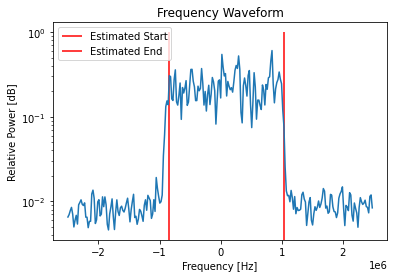


Angle -- NN Output:  -44.30188000202179 Actual Label:  -51.184185159003306
Start -- CNN Output:  944.6758422851562 Actual Label:  950.0
Stop -- CNN Output:  1575.911376953125 Actual Label:  1572.0


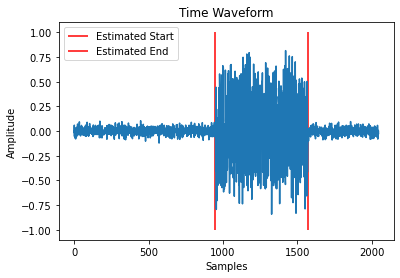

Center Frequency -- CNN Output:  0.008384637 Actual Label:  0.0016244
Bandwidth -- CNN Output:  0.7969716 Actual Label:  0.8005554


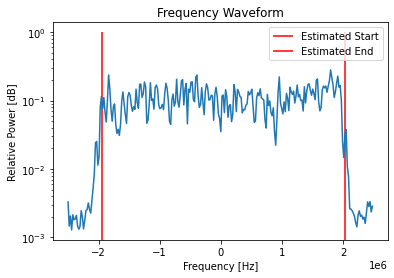


Angle -- NN Output:  -17.04268366098404 Actual Label:  -15.265075241379998
Start -- CNN Output:  725.2410278320312 Actual Label:  722.0
Stop -- CNN Output:  1799.478515625 Actual Label:  1791.0


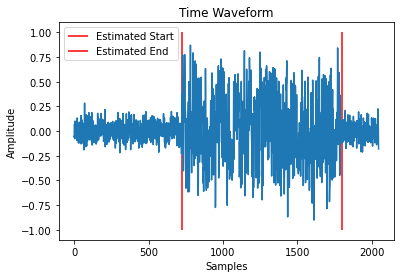

Center Frequency -- CNN Output:  -0.05842609 Actual Label:  -0.0612064
Bandwidth -- CNN Output:  0.3510075 Actual Label:  0.3394928



Angle -- NN Output:  -40.8590367436409 Actual Label:  -58.84467314659601
Start -- CNN Output:  1070.369873046875 Actual Label:  1074.0
Stop -- CNN Output:  1786.5892333984375 Actual Label:  1808.0


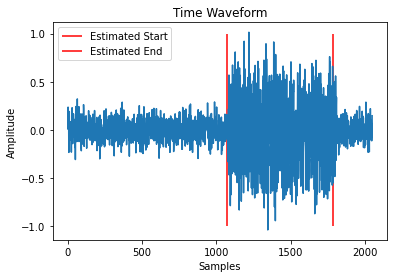

Center Frequency -- CNN Output:  0.014768697 Actual Label:  0.0039242
Bandwidth -- CNN Output:  0.74482477 Actual Label:  0.7535416


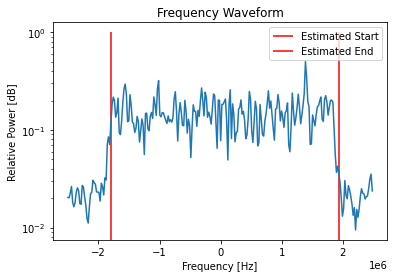

In [21]:
#This is just code to test the neural network to see how it is performing

for q in range(10):
        i = np.random.randint(0,len(timeX)) # Print the results for a random signal

        # Print the AoA, Start, Stop CNN predictions as well as the actual labels
        print("Angle -- NN Output: ", results[0][i,0]*180/np.pi*np.pi/2, "Actual Label: ", angleY[i]*180/np.pi*np.pi/2)
        print("Start -- CNN Output: ", results[1][i,0]*len(signal_0[0]), "Actual Label: ", timeY[i,0]*len(signal_0[0]))
        print("Stop -- CNN Output: ", results[1][i,1]*len(signal_0[0]), "Actual Label: ", timeY[i,1]*len(signal_0[0]))

        # Plot the time version of the signal as well as lines showing Estimated start/stop vs Actual start/stop
        plt.plot(range(len(timeX[i])), timeX[i])
        plt.vlines(x=round(results[1][i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
        #plt.vlines(x=round(test_timeY[i,0]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual Start')
        plt.vlines(x=round(results[1][i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated End')
        #plt.vlines(x=round(test_timeY[i,1]*len(signal_0[0])), ymin = -1, ymax = 1, colors = 'b', linestyles = 'dashed', label = 'Actual End')
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.title("Time Waveform")
        plt.legend()
        plt.show()

        # Print the frequency outputs of the NN
        print("Center Frequency -- CNN Output: ", results[2][i,0], "Actual Label: ", freqY[i,0])
        print("Bandwidth -- CNN Output: ", results[2][i,1], "Actual Label: ", freqY[i,1])

        # Plot the FFT of the signal
        f, P = signal.welch(timeX[i])
        f = np.fft.fftshift(f)*5e6
        P = np.fft.fftshift(P)

        # Plot vertical lines showing estimated bandwidth of the signal vs actual bandwidth and estimated center freq vs actual center freq
        start =(results[2][i,0] - results[2][i,1]/2)*5e6 # Calculates where the estimated "Start" of the signal is based off the bandwidth and cf prediction
        end =  (results[2][i,0] + results[2][i,1]/2)*5e6 # Calculates where the estimated "End" of the signal is based off the bandwidth and cf prediction
        act_start = (freqY[i,0] - timeY[i,1]/2)  # Calculates where the actual "Start" of the signal is based off the bandwidth and cf labels
        act_end = (freqY[i,0] + timeY[i,1]/2) # Calculates where the actual "End" of the signal is based off the bandwidth and cf labels

        center = results[2][i,0] # Predicted cf
        act_center = freqY[i,0] # Actual cf

        plt.semilogy(f,P)
        plt.vlines(x=start, ymin = -.1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated Start')
        #plt.vlines(x=act_start, ymin = -.1, ymax = 1, colors = 'g', linestyles = 'dashed', label = 'Actual Start')
        plt.vlines(x=end, ymin = -.1, ymax = 1, colors = 'r', linestyles = 'solid', label = 'Estimated End')
        #plt.vlines(x=act_end, ymin = -.1, ymax = 1, colors = 'g', linestyles = 'dashed', label = 'Actual End')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative Power [dB]")
        plt.title("Frequency Waveform")
        plt.legend()
        plt.show()
        print()

In [ ]:
plot_model(load_model, to_file="my_model.svg", show_shapes=True, dpi=)